<a href="https://colab.research.google.com/github/tasneemyo/Computer-Vision-Labs/blob/main/Assignment04/densenet_pet_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# File operations and system
from google.colab import files
import os

# Image processing
from PIL import Image
from torchvision import transforms, datasets, models
from torchvision.transforms import v2
from torchvision.transforms.functional import to_pil_image

# PyTorch core
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Metrics and evaluation
from sklearn.metrics import (accuracy_score, precision_score,
                           recall_score, f1_score, confusion_matrix,
                           classification_report, precision_recall_fscore_support)
# Utilities
import numpy as np
from tqdm import tqdm

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("anshtanwar/pets-facial-expression-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/pets-facial-expression-dataset


In [ ]:
data_path=path+"/Master Folder"

In [ ]:
val_test_transforms = v2.Compose([
    v2.Resize((224, 224), antialias=True), # resizing to the standard input size
    v2.ToTensor(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [ ]:
train_transforms = v2.Compose([
    v2.RandomResizedCrop(size=(224, 224), antialias=True),  # Augmentation
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToTensor(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

In [ ]:
train_dataset = datasets.ImageFolder(root=f"{data_path}/train", transform=train_transforms)
valid_dataset = datasets.ImageFolder(root=f"{data_path}/valid", transform=val_test_transforms)
test_dataset  = datasets.ImageFolder(root=f"{data_path}/test",  transform=val_test_transforms)

In [ ]:
print("Number of training images:", len(train_dataset))
print("Number of validation images:", len(valid_dataset))
print("Number of test images:", len(test_dataset))


Number of training images: 1000
Number of validation images: 36
Number of test images: 38


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False)

In [ ]:
len(train_loader), len(valid_loader), len(test_loader)

(32, 2, 2)

In [ ]:
for i, (inputs, labels) in enumerate(test_loader):
    print(f"Batch {i+1} size: {inputs.size(0)}")


Batch 1 size: 32
Batch 2 size: 6


In [ ]:
print("Class labels:", train_dataset.classes)

Class labels: ['Angry', 'Other', 'Sad', 'happy']


In [ ]:
images, labels = next(iter(test_loader))
print(images.shape)
print(images[0].shape)
print(labels)


torch.Size([32, 3, 224, 224])
torch.Size([3, 224, 224])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 3, 3, 3, 3, 3])


In [ ]:
np.max(np.array(images[0]))

np.float32(0.96862745)

In [ ]:
class_names=train_dataset.classes

In [ ]:
num_classes = len(class_names)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# **DenseNet 121**

https://medium.com/deepkapha-notes/implementing-densenet-121-in-pytorch-a-step-by-step-guide-c0c2625c2a60

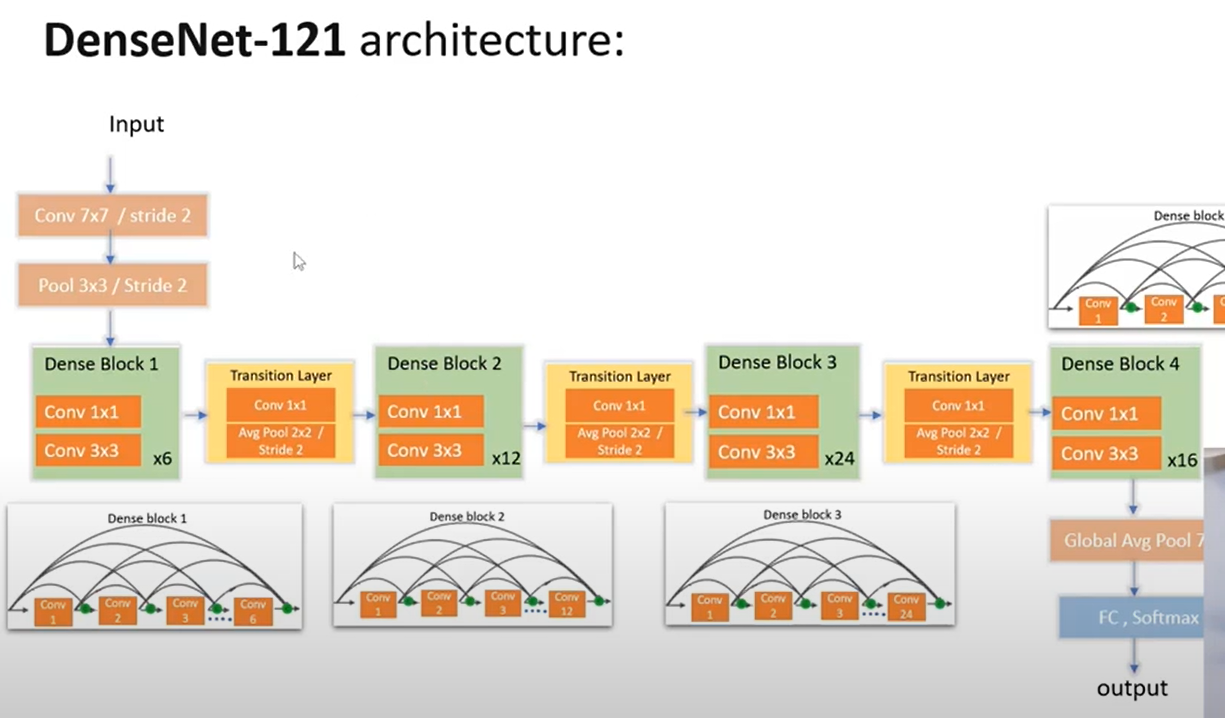

Notes:

- DenseBlock = x * DenseLayer
- DenseLayer = Conv1x1 + Conv3x3
- Conv = BatchNorm -> ReLU -> Conv



In [ ]:
# 5. DenseNet121
class _DenseLayer(nn.Module):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate):
        super().__init__()
        self.norm1 = nn.BatchNorm2d(num_input_features)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(num_input_features, bn_size * growth_rate, kernel_size=1, stride=1, bias=False)

        self.norm2 = nn.BatchNorm2d(bn_size * growth_rate)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(bn_size * growth_rate, growth_rate, kernel_size=3, stride=1, padding=1, bias=False)

        self.drop_rate = drop_rate

    def forward(self, x):
        out = self.conv1(self.relu1(self.norm1(x)))
        out = self.conv2(self.relu2(self.norm2(out)))
        if self.drop_rate > 0:
            out = F.dropout(out, p=self.drop_rate, training=self.training)
        return torch.cat([x, out], 1)


In [ ]:
class _DenseBlock(nn.Module):
    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate):
        super().__init__()
        self.layers = nn.ModuleList()
        for i in range(num_layers):
            layer = _DenseLayer(
                num_input_features + i * growth_rate,
                growth_rate=growth_rate,
                bn_size=bn_size,
                drop_rate=drop_rate,
            )
            self.layers.append(layer)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

- Transition: conv1x1 -> avg pooling 2x2 s=2

In [ ]:
class _Transition(nn.Module):
    def __init__(self, num_input_features, num_output_features):
        super().__init__()
        self.norm = nn.BatchNorm2d(num_input_features)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(num_input_features, num_output_features, kernel_size=1, stride=1, bias=False)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv(self.relu(self.norm(x)))
        x = self.pool(x)
        return x


In [ ]:
class DenseNet121(nn.Module):
    def __init__(self, num_classes=num_classes, growth_rate=32, block_config=(6, 12, 24, 16),
                 num_init_features=64, bn_size=4, drop_rate=0):
        super().__init__()

        # initial conv
        self.features = nn.Sequential(
            nn.Conv2d(3, num_init_features, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(num_init_features),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )

        # Dense blocks
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
                drop_rate=drop_rate,
            )
            self.features.add_module(f'denseblock{i+1}', block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features, num_output_features=num_features // 2)
                self.features.add_module(f'transition{i+1}', trans)
                num_features = num_features // 2

        # final batch norm
        self.features.add_module('norm5', nn.BatchNorm2d(num_features))

        # classific
        self.classifier = nn.Linear(num_features, num_classes)

        # weights init
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return out

In [ ]:
model = DenseNet121(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
# def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=10):
#     best_acc = 0.0
#     for epoch in range(num_epochs):
#         print(f'Epoch {epoch+1}/{num_epochs}')
#         print('-' * 10)

#         # Training phase
#         model.train()
#         running_loss = 0.0
#         running_corrects = 0

#         for inputs, labels in train_loader:
#             inputs, labels = inputs.to(device), labels.to(device)

#             optimizer.zero_grad()
#             outputs = model(inputs)
#             _, preds = torch.max(outputs, 1)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

#             running_loss += loss.item() * inputs.size(0)
#             running_corrects += torch.sum(preds == labels.data)

#         epoch_loss = running_loss / len(train_dataset)
#         epoch_acc = running_corrects.double() / len(train_dataset)
#         print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

#         # Validation phase
#         model.eval()
#         val_loss = 0.0
#         val_corrects = 0
#         all_preds = []
#         all_labels = []

#         with torch.no_grad():
#             for inputs, labels in valid_loader:
#                 inputs, labels = inputs.to(device), labels.to(device)
#                 outputs = model(inputs)
#                 _, preds = torch.max(outputs, 1)
#                 loss = criterion(outputs, labels)

#                 val_loss += loss.item() * inputs.size(0)
#                 val_corrects += torch.sum(preds == labels.data)
#                 all_preds.extend(preds.cpu().numpy())
#                 all_labels.extend(labels.cpu().numpy())

#         val_loss = val_loss / len(valid_dataset)
#         val_acc = val_corrects.double() / len(valid_dataset)

#         # metrics
#         precision, recall, f1, _ = precision_recall_fscore_support(
#             all_labels, all_preds, average='weighted')

#         print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
#         print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}')

#         # best model
#         if val_acc > best_acc:
#             best_acc = val_acc
#             torch.save(model.state_dict(), 'best_densenet121.pth')

#     return model

def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=10):
    best_acc = 0.0
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_corrects.double() / len(train_dataset)
        train_losses.append(epoch_loss)
        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_loss = val_loss / len(valid_dataset)
        val_acc = val_corrects.double() / len(valid_dataset)
        val_losses.append(val_loss)

        # metrics
        precision, recall, f1, _ = precision_recall_fscore_support(
            all_labels, all_preds, average='weighted')

        print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}')

        # best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_densenet121.pth')

    plt.figure(figsize=(8, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    return model


Epoch 1/50
----------
Train Loss: 1.4779 Acc: 0.3180
Val Loss: 1.5574 Acc: 0.3056
Precision: 0.3393, Recall: 0.3056, F1: 0.2644
Epoch 2/50
----------
Train Loss: 1.3981 Acc: 0.3060
Val Loss: 1.7061 Acc: 0.2222
Precision: 0.2600, Recall: 0.2222, F1: 0.2045
Epoch 3/50
----------
Train Loss: 1.3730 Acc: 0.3270
Val Loss: 1.8627 Acc: 0.1944
Precision: 0.1840, Recall: 0.1944, F1: 0.1535
Epoch 4/50
----------
Train Loss: 1.3824 Acc: 0.3260
Val Loss: 1.5340 Acc: 0.3056
Precision: 0.3880, Recall: 0.3056, F1: 0.3210
Epoch 5/50
----------
Train Loss: 1.3826 Acc: 0.2920


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Val Loss: 1.5871 Acc: 0.1944
Precision: 0.0530, Recall: 0.1944, F1: 0.0833
Epoch 6/50
----------
Train Loss: 1.3611 Acc: 0.3500
Val Loss: 1.4918 Acc: 0.2500
Precision: 0.2521, Recall: 0.2500, F1: 0.2003
Epoch 7/50
----------
Train Loss: 1.3380 Acc: 0.3550
Val Loss: 1.8157 Acc: 0.2500
Precision: 0.2100, Recall: 0.2500, F1: 0.2147
Epoch 8/50
----------
Train Loss: 1.3391 Acc: 0.3700
Val Loss: 1.5122 Acc: 0.2500
Precision: 0.2552, Recall: 0.2500, F1: 0.2342
Epoch 9/50
----------
Train Loss: 1.3142 Acc: 0.4030
Val Loss: 1.4854 Acc: 0.3056
Precision: 0.2091, Recall: 0.3056, F1: 0.2467
Epoch 10/50
----------
Train Loss: 1.3501 Acc: 0.3520
Val Loss: 4.1547 Acc: 0.3333
Precision: 0.3140, Recall: 0.3333, F1: 0.2636
Epoch 11/50
----------
Train Loss: 1.2977 Acc: 0.3940
Val Loss: 1.8043 Acc: 0.2778
Precision: 0.1912, Recall: 0.2778, F1: 0.1817
Epoch 12/50
----------
Train Loss: 1.3250 Acc: 0.3700
Val Loss: 1.8790 Acc: 0.3333
Precision: 0.3808, Recall: 0.3333, F1: 0.3154
Epoch 13/50
----------
Tra

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Val Loss: 1.4602 Acc: 0.3333
Precision: 0.1907, Recall: 0.3333, F1: 0.2426
Epoch 17/50
----------
Train Loss: 1.2473 Acc: 0.4160
Val Loss: 2.5427 Acc: 0.2778
Precision: 0.4241, Recall: 0.2778, F1: 0.2701
Epoch 18/50
----------
Train Loss: 1.2692 Acc: 0.3980


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Val Loss: 2.1032 Acc: 0.2222
Precision: 0.1622, Recall: 0.2222, F1: 0.1865
Epoch 19/50
----------
Train Loss: 1.2520 Acc: 0.4060
Val Loss: 2.0763 Acc: 0.2778
Precision: 0.1895, Recall: 0.2778, F1: 0.2245
Epoch 20/50
----------
Train Loss: 1.2418 Acc: 0.4460
Val Loss: 1.7958 Acc: 0.3056
Precision: 0.4138, Recall: 0.3056, F1: 0.2874
Epoch 21/50
----------
Train Loss: 1.2412 Acc: 0.4220
Val Loss: 1.5405 Acc: 0.3056
Precision: 0.3203, Recall: 0.3056, F1: 0.2927
Epoch 22/50
----------
Train Loss: 1.2387 Acc: 0.4100
Val Loss: 2.9800 Acc: 0.2778
Precision: 0.1618, Recall: 0.2778, F1: 0.1993
Epoch 23/50
----------
Train Loss: 1.2178 Acc: 0.4480


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Val Loss: 1.6377 Acc: 0.2778
Precision: 0.2361, Recall: 0.2778, F1: 0.2387
Epoch 24/50
----------
Train Loss: 1.2615 Acc: 0.4220
Val Loss: 1.7963 Acc: 0.2778
Precision: 0.2905, Recall: 0.2778, F1: 0.2691
Epoch 25/50
----------
Train Loss: 1.2035 Acc: 0.4420
Val Loss: 1.5041 Acc: 0.3333
Precision: 0.3517, Recall: 0.3333, F1: 0.3356
Epoch 26/50
----------
Train Loss: 1.1934 Acc: 0.4530
Val Loss: 2.1233 Acc: 0.3056
Precision: 0.3611, Recall: 0.3056, F1: 0.3017
Epoch 27/50
----------
Train Loss: 1.2093 Acc: 0.4420
Val Loss: 1.5247 Acc: 0.3333
Precision: 0.3479, Recall: 0.3333, F1: 0.3389
Epoch 28/50
----------
Train Loss: 1.1988 Acc: 0.4540
Val Loss: 2.1935 Acc: 0.3056
Precision: 0.3047, Recall: 0.3056, F1: 0.2922
Epoch 29/50
----------
Train Loss: 1.2006 Acc: 0.4490
Val Loss: 2.1029 Acc: 0.3333
Precision: 0.4284, Recall: 0.3333, F1: 0.3000
Epoch 30/50
----------
Train Loss: 1.1939 Acc: 0.4540
Val Loss: 1.4566 Acc: 0.3056
Precision: 0.3030, Recall: 0.3056, F1: 0.2917
Epoch 31/50
----------

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Val Loss: 1.4916 Acc: 0.3056
Precision: 0.2101, Recall: 0.3056, F1: 0.2448
Epoch 37/50
----------
Train Loss: 1.1204 Acc: 0.4870
Val Loss: 2.5148 Acc: 0.2500
Precision: 0.1942, Recall: 0.2500, F1: 0.1950
Epoch 38/50
----------
Train Loss: 1.1883 Acc: 0.4690
Val Loss: 1.7465 Acc: 0.3333
Precision: 0.3042, Recall: 0.3333, F1: 0.3148
Epoch 39/50
----------
Train Loss: 1.0973 Acc: 0.5320
Val Loss: 1.6608 Acc: 0.3333
Precision: 0.3107, Recall: 0.3333, F1: 0.3185
Epoch 40/50
----------
Train Loss: 1.1231 Acc: 0.5210
Val Loss: 1.8356 Acc: 0.3333
Precision: 0.3317, Recall: 0.3333, F1: 0.3280
Epoch 41/50
----------
Train Loss: 1.0637 Acc: 0.5440
Val Loss: 2.0300 Acc: 0.2778
Precision: 0.2771, Recall: 0.2778, F1: 0.2717
Epoch 42/50
----------
Train Loss: 1.1087 Acc: 0.4960
Val Loss: 2.3921 Acc: 0.3056
Precision: 0.2689, Recall: 0.3056, F1: 0.2724
Epoch 43/50
----------
Train Loss: 1.0494 Acc: 0.5470
Val Loss: 1.7693 Acc: 0.2500
Precision: 0.3214, Recall: 0.2500, F1: 0.2220
Epoch 44/50
----------

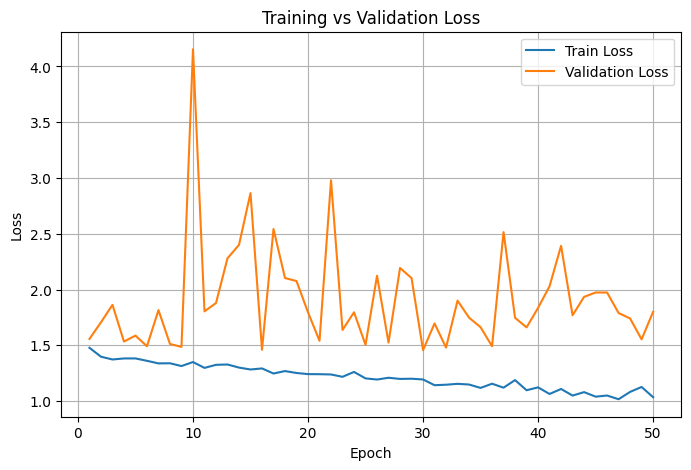

In [ ]:
model = train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=50)



In [ ]:
# --- Evaluation Function ---
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = sum(1 for x,y in zip(all_preds, all_labels) if x == y) / len(all_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='weighted')

    print(f'Test Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


Test Accuracy: 0.5000
Precision: 0.4830
Recall: 0.5000
F1 Score: 0.4720


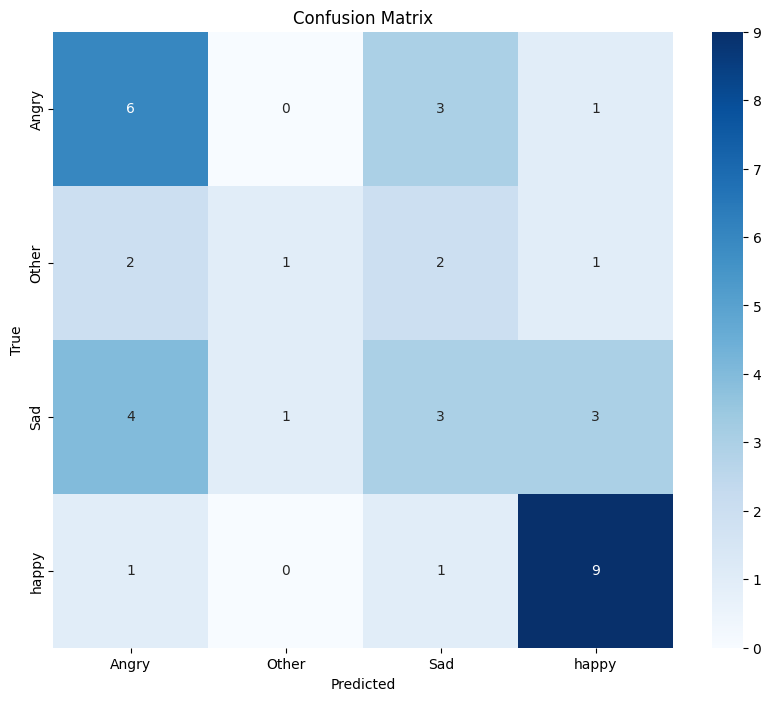

In [ ]:
model.load_state_dict(torch.load('best_densenet121.pth'))
evaluate_model(model, test_loader)

------------------------------------------

## Transfer Learning (Using Inception V3)

 1. Loading Pretrained InceptionV3

In [ ]:
print(f"{data_path}/train")

/kaggle/input/pets-facial-expression-dataset/Master Folder/train


In [ ]:
train_transforms = v2.Compose([
    v2.RandomResizedCrop(299),  # since it expects 299x299
    v2.RandomHorizontalFlip(),
    v2.ToTensor(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet stats
])

val_test_transforms = v2.Compose([
    v2.Resize(299),
    v2.CenterCrop(299),
    v2.ToTensor(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = datasets.ImageFolder(root=f"{data_path}/train", transform=train_transforms)
valid_dataset = datasets.ImageFolder(root=f"{data_path}/valid", transform=val_test_transforms)
test_dataset  = datasets.ImageFolder(root=f"{data_path}/test",  transform=val_test_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
model = models.inception_v3(weights='IMAGENET1K_V1')

# handling auxiliary net
num_ftrs = model.AuxLogits.fc.in_features
model.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)

# handling primary net
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

model = model.to(device)


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 182MB/s] 


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=50):
    best_acc = 0.0
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # train
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            # train mode soo we get both outputs
            outputs, aux_outputs = model(inputs)

            # weighted loss
            loss = criterion(outputs, labels) + 0.4 * criterion(aux_outputs, labels)

            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_corrects.double() / len(train_dataset)
        train_losses.append(epoch_loss)
        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # bal
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                # In eval mode, we only get main outputs
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_loss = val_loss / len(valid_dataset)
        val_acc = val_corrects.double() / len(valid_dataset)
        val_losses.append(val_loss)

        precision, recall, f1, _ = precision_recall_fscore_support(
            all_labels, all_preds, average='weighted')

        print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}')

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_inceptionv3.pth')
            print(best_acc)

    # Plot training history
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model

In [ ]:
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)  # eval mode soo only single output is returned
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = sum(1 for x,y in zip(all_preds, all_labels) if x == y) / len(all_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='weighted')

    print(f'\nTest Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=train_dataset.classes,
                yticklabels=train_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

Epoch 1/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.5857 Acc: 0.8280
Val Loss: 2.4507 Acc: 0.4444
Precision: 0.5370, Recall: 0.4444, F1: 0.4226
tensor(0.4444, device='cuda:0', dtype=torch.float64)
Epoch 2/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.5425 Acc: 0.8580
Val Loss: 1.8350 Acc: 0.5556
Precision: 0.5747, Recall: 0.5556, F1: 0.5317
tensor(0.5556, device='cuda:0', dtype=torch.float64)
Epoch 3/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.5428 Acc: 0.8620
Val Loss: 2.6538 Acc: 0.3889
Precision: 0.3854, Recall: 0.3889, F1: 0.3407
Epoch 4/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.5875 Acc: 0.8400
Val Loss: 1.4359 Acc: 0.5000
Precision: 0.4975, Recall: 0.5000, F1: 0.4938
Epoch 5/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.6902 Acc: 0.8070
Val Loss: 1.5906 Acc: 0.6111
Precision: 0.4809, Recall: 0.6111, F1: 0.5265
tensor(0.6111, device='cuda:0', dtype=torch.float64)
Epoch 6/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.6366 Acc: 0.8200
Val Loss: 2.2587 Acc: 0.4722
Precision: 0.3918, Recall: 0.4722, F1: 0.4174
Epoch 7/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.6049 Acc: 0.8470
Val Loss: 1.7874 Acc: 0.4722
Precision: 0.3988, Recall: 0.4722, F1: 0.4157
Epoch 8/50
----------


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.5524 Acc: 0.8510
Val Loss: 2.4917 Acc: 0.3611
Precision: 0.3509, Recall: 0.3611, F1: 0.3413
Epoch 9/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.5108 Acc: 0.8630
Val Loss: 1.9008 Acc: 0.4444
Precision: 0.4430, Recall: 0.4444, F1: 0.4189
Epoch 10/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.5135 Acc: 0.8520
Val Loss: 2.2280 Acc: 0.3889
Precision: 0.3796, Recall: 0.3889, F1: 0.3512
Epoch 11/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.5395 Acc: 0.8570
Val Loss: 2.1978 Acc: 0.3611
Precision: 0.2599, Recall: 0.3611, F1: 0.3015
Epoch 12/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.4859 Acc: 0.8770
Val Loss: 2.2111 Acc: 0.5000
Precision: 0.4140, Recall: 0.5000, F1: 0.4227
Epoch 13/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.4355 Acc: 0.8830
Val Loss: 2.3310 Acc: 0.5000
Precision: 0.5381, Recall: 0.5000, F1: 0.4938
Epoch 14/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.4934 Acc: 0.8680
Val Loss: 2.0765 Acc: 0.4722
Precision: 0.4831, Recall: 0.4722, F1: 0.4752
Epoch 15/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.5223 Acc: 0.8540
Val Loss: 2.4068 Acc: 0.3611
Precision: 0.3234, Recall: 0.3611, F1: 0.3399
Epoch 16/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.5703 Acc: 0.8400
Val Loss: 1.7641 Acc: 0.5000
Precision: 0.5405, Recall: 0.5000, F1: 0.5111
Epoch 17/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.5281 Acc: 0.8570
Val Loss: 1.9884 Acc: 0.4167
Precision: 0.3618, Recall: 0.4167, F1: 0.3801
Epoch 18/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.6082 Acc: 0.8320
Val Loss: 2.9187 Acc: 0.5278
Precision: 0.3912, Recall: 0.5278, F1: 0.4445
Epoch 19/50
----------


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.5968 Acc: 0.8490
Val Loss: 2.6013 Acc: 0.4722
Precision: 0.5174, Recall: 0.4722, F1: 0.4417
Epoch 20/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.5638 Acc: 0.8380
Val Loss: 2.4576 Acc: 0.4722
Precision: 0.3902, Recall: 0.4722, F1: 0.4166
Epoch 21/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.5545 Acc: 0.8560
Val Loss: 2.2371 Acc: 0.5278
Precision: 0.4715, Recall: 0.5278, F1: 0.4887
Epoch 22/50
----------


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.4216 Acc: 0.8870
Val Loss: 2.1288 Acc: 0.4722
Precision: 0.4398, Recall: 0.4722, F1: 0.4216
Epoch 23/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.4145 Acc: 0.8950
Val Loss: 2.0118 Acc: 0.5278
Precision: 0.5397, Recall: 0.5278, F1: 0.5180
Epoch 24/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.4950 Acc: 0.8720
Val Loss: 2.3703 Acc: 0.4167
Precision: 0.4492, Recall: 0.4167, F1: 0.4048
Epoch 25/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.5044 Acc: 0.8570
Val Loss: 2.0659 Acc: 0.3611
Precision: 0.3721, Recall: 0.3611, F1: 0.3368
Epoch 26/50
----------


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.4360 Acc: 0.8730
Val Loss: 1.8169 Acc: 0.4444
Precision: 0.3924, Recall: 0.4444, F1: 0.4115
Epoch 27/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.4892 Acc: 0.8650
Val Loss: 2.8088 Acc: 0.4167
Precision: 0.4653, Recall: 0.4167, F1: 0.4288
Epoch 28/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.4392 Acc: 0.8770
Val Loss: 2.3775 Acc: 0.3333
Precision: 0.2926, Recall: 0.3333, F1: 0.3071
Epoch 29/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.3930 Acc: 0.8990
Val Loss: 2.2007 Acc: 0.4167
Precision: 0.3512, Recall: 0.4167, F1: 0.3702
Epoch 30/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.3801 Acc: 0.9080
Val Loss: 2.3711 Acc: 0.4722
Precision: 0.4430, Recall: 0.4722, F1: 0.4330
Epoch 31/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.3599 Acc: 0.9090
Val Loss: 2.5679 Acc: 0.5278
Precision: 0.6903, Recall: 0.5278, F1: 0.4935
Epoch 32/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.3894 Acc: 0.8960
Val Loss: 2.9330 Acc: 0.4167
Precision: 0.3306, Recall: 0.4167, F1: 0.3587
Epoch 33/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.4600 Acc: 0.8790
Val Loss: 2.0646 Acc: 0.5278
Precision: 0.5227, Recall: 0.5278, F1: 0.5244
Epoch 34/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.4545 Acc: 0.8720
Val Loss: 2.0220 Acc: 0.5833
Precision: 0.5725, Recall: 0.5833, F1: 0.5515
Epoch 35/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.4229 Acc: 0.8820
Val Loss: 2.2938 Acc: 0.4167
Precision: 0.4056, Recall: 0.4167, F1: 0.3897
Epoch 36/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.4688 Acc: 0.8780
Val Loss: 1.8566 Acc: 0.5556
Precision: 0.5449, Recall: 0.5556, F1: 0.5043
Epoch 37/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.5155 Acc: 0.8700
Val Loss: 1.9177 Acc: 0.5278
Precision: 0.5332, Recall: 0.5278, F1: 0.5122
Epoch 38/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.4904 Acc: 0.8730
Val Loss: 2.2081 Acc: 0.5000
Precision: 0.5046, Recall: 0.5000, F1: 0.5004
Epoch 39/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.4968 Acc: 0.8710
Val Loss: 2.2138 Acc: 0.3889
Precision: 0.3224, Recall: 0.3889, F1: 0.3504
Epoch 40/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.3735 Acc: 0.8990
Val Loss: 1.6950 Acc: 0.5278
Precision: 0.5388, Recall: 0.5278, F1: 0.5302
Epoch 41/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.4151 Acc: 0.8920
Val Loss: 2.5570 Acc: 0.4444
Precision: 0.4745, Recall: 0.4444, F1: 0.4414
Epoch 42/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.3747 Acc: 0.9110
Val Loss: 2.2753 Acc: 0.5000
Precision: 0.4519, Recall: 0.5000, F1: 0.4676
Epoch 43/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.3413 Acc: 0.9060
Val Loss: 2.4513 Acc: 0.4444
Precision: 0.5198, Recall: 0.4444, F1: 0.4250
Epoch 44/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.4773 Acc: 0.8750
Val Loss: 2.6311 Acc: 0.4722
Precision: 0.3701, Recall: 0.4722, F1: 0.4060
Epoch 45/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.5326 Acc: 0.8640
Val Loss: 2.4430 Acc: 0.5278
Precision: 0.5383, Recall: 0.5278, F1: 0.5094
Epoch 46/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.4438 Acc: 0.8780
Val Loss: 1.9870 Acc: 0.5278
Precision: 0.5850, Recall: 0.5278, F1: 0.4969
Epoch 47/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.3584 Acc: 0.9040
Val Loss: 2.2136 Acc: 0.4444
Precision: 0.4471, Recall: 0.4444, F1: 0.4267
Epoch 48/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.3689 Acc: 0.9010
Val Loss: 2.2854 Acc: 0.4167
Precision: 0.4012, Recall: 0.4167, F1: 0.3956
Epoch 49/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.3844 Acc: 0.8930
Val Loss: 2.5879 Acc: 0.4444
Precision: 0.4172, Recall: 0.4444, F1: 0.4215
Epoch 50/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.3167 Acc: 0.9210
Val Loss: 2.5746 Acc: 0.3611
Precision: 0.2770, Recall: 0.3611, F1: 0.3114


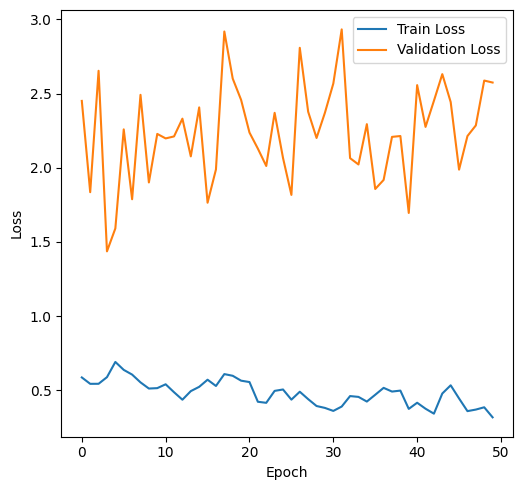

In [ ]:
model = train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=50)

Best Validation Accuracy (E6): 0.6111


Evaluating best model on test set...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Test Accuracy: 0.5263
Precision: 0.5465
Recall: 0.5263
F1 Score: 0.5042


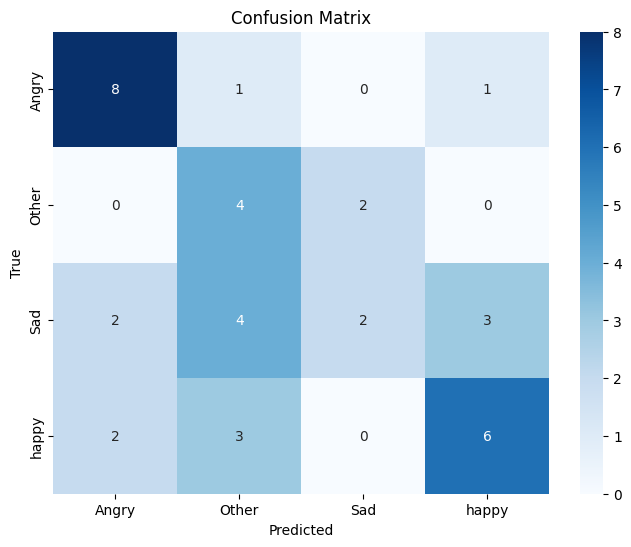

In [ ]:
print("\nEvaluating best model on test set...")
model.load_state_dict(torch.load('best_inceptionv3.pth'))
evaluate_model(model, test_loader)

--------------------------------------------------

--------------------------------
# Freezing All Layers

In [23]:
model = models.inception_v3(weights='IMAGENET1K_V1')

# auxiliary classifier modif
num_ftrs_aux = model.AuxLogits.fc.in_features
model.AuxLogits.fc = nn.Linear(num_ftrs_aux, num_classes)

# main classifier modif
num_ftrs_main = model.fc.in_features
model.fc = nn.Linear(num_ftrs_main, num_classes)

for param in model.parameters():
    param.requires_grad = False

#  unfreeze layers elclassification
for param in model.AuxLogits.fc.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

model = model.to(device)

# (only training classifier parameters)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()), lr=0.001
)

Epoch 1/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 1.9132 Acc: 0.3340


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Val Loss: 1.2832 Acc: 0.3889
Precision: 0.2976, Recall: 0.3889, F1: 0.3160
tensor(0.3889, device='cuda:0', dtype=torch.float64)
Epoch 2/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 1.7585 Acc: 0.4150
Val Loss: 1.3092 Acc: 0.3889
Precision: 0.3849, Recall: 0.3889, F1: 0.3576
Epoch 3/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 1.6731 Acc: 0.4540
Val Loss: 1.3102 Acc: 0.3889
Precision: 0.4314, Recall: 0.3889, F1: 0.3855
Epoch 4/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 1.6440 Acc: 0.4520
Val Loss: 1.4920 Acc: 0.3889
Precision: 0.4630, Recall: 0.3889, F1: 0.3404
Epoch 5/50
----------


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 1.6315 Acc: 0.4810
Val Loss: 1.2893 Acc: 0.5000
Precision: 0.5634, Recall: 0.5000, F1: 0.4917
tensor(0.5000, device='cuda:0', dtype=torch.float64)
Epoch 6/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 1.5611 Acc: 0.5130
Val Loss: 1.3318 Acc: 0.4167
Precision: 0.4870, Recall: 0.4167, F1: 0.4097
Epoch 7/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 1.5279 Acc: 0.5190
Val Loss: 1.3292 Acc: 0.4444
Precision: 0.5028, Recall: 0.4444, F1: 0.4408
Epoch 8/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 1.5315 Acc: 0.5130
Val Loss: 1.2624 Acc: 0.4444
Precision: 0.5035, Recall: 0.4444, F1: 0.4406
Epoch 9/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 1.5007 Acc: 0.5340
Val Loss: 1.3118 Acc: 0.4167
Precision: 0.4689, Recall: 0.4167, F1: 0.4115
Epoch 10/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 1.4934 Acc: 0.5270
Val Loss: 1.2859 Acc: 0.4444
Precision: 0.5243, Recall: 0.4444, F1: 0.4460
Epoch 11/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 1.4777 Acc: 0.5430
Val Loss: 1.3551 Acc: 0.3889
Precision: 0.4578, Recall: 0.3889, F1: 0.3742
Epoch 12/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 1.4660 Acc: 0.5510
Val Loss: 1.3466 Acc: 0.3889
Precision: 0.4585, Recall: 0.3889, F1: 0.3751
Epoch 13/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 1.4140 Acc: 0.5580
Val Loss: 1.2650 Acc: 0.4444
Precision: 0.4733, Recall: 0.4444, F1: 0.4356
Epoch 14/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 1.4396 Acc: 0.5510
Val Loss: 1.3547 Acc: 0.4444
Precision: 0.4735, Recall: 0.4444, F1: 0.4363
Epoch 15/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 1.4100 Acc: 0.5700
Val Loss: 1.3280 Acc: 0.4167
Precision: 0.4151, Recall: 0.4167, F1: 0.3889
Epoch 16/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 1.4325 Acc: 0.5440
Val Loss: 1.4148 Acc: 0.3889
Precision: 0.4706, Recall: 0.3889, F1: 0.3777
Epoch 17/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 1.4139 Acc: 0.5560
Val Loss: 1.3376 Acc: 0.4722
Precision: 0.4917, Recall: 0.4722, F1: 0.4561
Epoch 18/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 1.4335 Acc: 0.5720
Val Loss: 1.3534 Acc: 0.4722
Precision: 0.5278, Recall: 0.4722, F1: 0.4621
Epoch 19/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 1.4523 Acc: 0.5560
Val Loss: 1.2869 Acc: 0.4722
Precision: 0.5087, Recall: 0.4722, F1: 0.4697
Epoch 20/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 1.3746 Acc: 0.5910
Val Loss: 1.3112 Acc: 0.4722
Precision: 0.4971, Recall: 0.4722, F1: 0.4571
Epoch 21/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 1.3783 Acc: 0.5710
Val Loss: 1.3024 Acc: 0.4167
Precision: 0.4571, Recall: 0.4167, F1: 0.4084
Epoch 22/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 1.3919 Acc: 0.5670
Val Loss: 1.3417 Acc: 0.4722
Precision: 0.6130, Recall: 0.4722, F1: 0.4764
Epoch 23/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 1.3899 Acc: 0.5670
Val Loss: 1.3626 Acc: 0.4167
Precision: 0.4571, Recall: 0.4167, F1: 0.4084
Epoch 24/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 1.3620 Acc: 0.5880
Val Loss: 1.2399 Acc: 0.5000
Precision: 0.5344, Recall: 0.5000, F1: 0.4934
Epoch 25/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 1.3584 Acc: 0.5850
Val Loss: 1.3577 Acc: 0.4722
Precision: 0.4971, Recall: 0.4722, F1: 0.4571
Epoch 26/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 1.3296 Acc: 0.5990
Val Loss: 1.3096 Acc: 0.4444
Precision: 0.4813, Recall: 0.4444, F1: 0.4409
Epoch 27/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 1.3516 Acc: 0.5850
Val Loss: 1.3683 Acc: 0.4722
Precision: 0.5278, Recall: 0.4722, F1: 0.4621
Epoch 28/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 1.3798 Acc: 0.5730
Val Loss: 1.2525 Acc: 0.4444
Precision: 0.4735, Recall: 0.4444, F1: 0.4363
Epoch 29/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 1.3585 Acc: 0.5850
Val Loss: 1.3078 Acc: 0.4722
Precision: 0.4917, Recall: 0.4722, F1: 0.4561
Epoch 30/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 1.3726 Acc: 0.5630
Val Loss: 1.3390 Acc: 0.4444
Precision: 0.4757, Recall: 0.4444, F1: 0.4247
Epoch 31/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 1.3758 Acc: 0.5660
Val Loss: 1.3049 Acc: 0.4444
Precision: 0.4813, Recall: 0.4444, F1: 0.4409
Epoch 32/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 1.3220 Acc: 0.5880
Val Loss: 1.4013 Acc: 0.4167
Precision: 0.4846, Recall: 0.4167, F1: 0.4133
Epoch 33/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 1.2863 Acc: 0.6250
Val Loss: 1.2825 Acc: 0.5000
Precision: 0.5188, Recall: 0.5000, F1: 0.4914
Epoch 34/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 1.3205 Acc: 0.6030
Val Loss: 1.4488 Acc: 0.4167
Precision: 0.4519, Recall: 0.4167, F1: 0.4049
Epoch 35/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 1.3437 Acc: 0.5940
Val Loss: 1.3698 Acc: 0.4722
Precision: 0.4971, Recall: 0.4722, F1: 0.4571
Epoch 36/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 1.3213 Acc: 0.6050
Val Loss: 1.3586 Acc: 0.4722
Precision: 0.5393, Recall: 0.4722, F1: 0.4651
Epoch 37/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 1.3512 Acc: 0.5880
Val Loss: 1.2442 Acc: 0.5000
Precision: 0.5281, Recall: 0.5000, F1: 0.5011
Epoch 38/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 1.3578 Acc: 0.5660
Val Loss: 1.3987 Acc: 0.4722
Precision: 0.5081, Recall: 0.4722, F1: 0.4597
Epoch 39/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 1.3713 Acc: 0.5630
Val Loss: 1.3850 Acc: 0.4167
Precision: 0.4870, Recall: 0.4167, F1: 0.4097
Epoch 40/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 1.2325 Acc: 0.6200
Val Loss: 1.3329 Acc: 0.5278
Precision: 0.5584, Recall: 0.5278, F1: 0.5235
tensor(0.5278, device='cuda:0', dtype=torch.float64)
Epoch 41/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 1.3266 Acc: 0.5850
Val Loss: 1.3043 Acc: 0.5000
Precision: 0.5195, Recall: 0.5000, F1: 0.4929
Epoch 42/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 1.3441 Acc: 0.5900
Val Loss: 1.3249 Acc: 0.4722
Precision: 0.4116, Recall: 0.4722, F1: 0.4263
Epoch 43/50
----------


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 1.2748 Acc: 0.6000
Val Loss: 1.4058 Acc: 0.4722
Precision: 0.4971, Recall: 0.4722, F1: 0.4571
Epoch 44/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 1.3366 Acc: 0.5980
Val Loss: 1.4153 Acc: 0.4722
Precision: 0.5440, Recall: 0.4722, F1: 0.4638
Epoch 45/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 1.3156 Acc: 0.5830
Val Loss: 1.3726 Acc: 0.4444
Precision: 0.4682, Recall: 0.4444, F1: 0.4247
Epoch 46/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 1.3024 Acc: 0.5810
Val Loss: 1.3771 Acc: 0.4444
Precision: 0.4682, Recall: 0.4444, F1: 0.4247
Epoch 47/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 1.3456 Acc: 0.5740
Val Loss: 1.3134 Acc: 0.4722
Precision: 0.5007, Recall: 0.4722, F1: 0.4541
Epoch 48/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 1.2694 Acc: 0.6110
Val Loss: 1.3611 Acc: 0.4167
Precision: 0.4416, Recall: 0.4167, F1: 0.3993
Epoch 49/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 1.3036 Acc: 0.5860
Val Loss: 1.2878 Acc: 0.4444
Precision: 0.4897, Recall: 0.4444, F1: 0.4452
Epoch 50/50
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 1.2625 Acc: 0.6150
Val Loss: 1.3330 Acc: 0.4722
Precision: 0.4971, Recall: 0.4722, F1: 0.4571


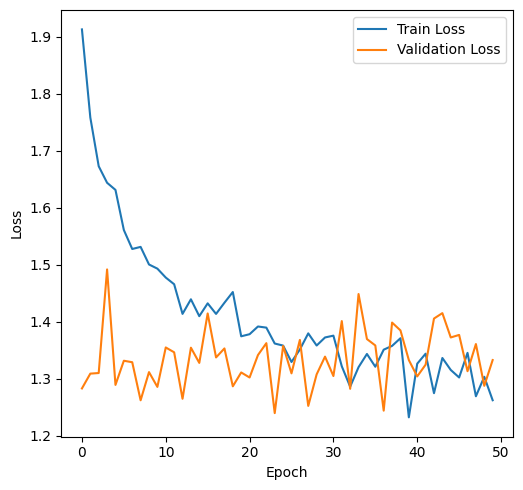

In [24]:
model = train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=50)

Best Validation accuracy: 0.50


Evaluating best model on test set...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Test Accuracy: 0.4211
Precision: 0.4335
Recall: 0.4211
F1 Score: 0.4074


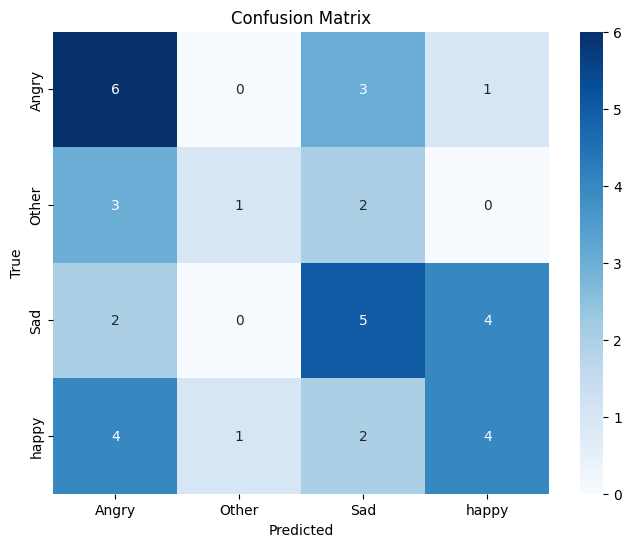

In [25]:
print("\nEvaluating best model on test set...")
model.load_state_dict(torch.load('best_inceptionv3.pth'))
evaluate_model(model, test_loader)
